# Model Monitoring for Cardiac Image Segmentation

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9d3d3f7a-d992-09dd-3e24-bddbea0a378c)


In [2]:
!rm -r sample_data

## Import data

In [4]:
!git clone https://github.com/manigalati/quality_control_CMR

Cloning into 'quality_control_CMR'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 49 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [5]:
%cd /content/quality_control_CMR

/content/quality_control_CMR


In [6]:
!mkdir data
#training set
!python gdrivedl.py https://drive.google.com/open?id=1bxRj0zf-iMooYA4jUZS_zS4VD9NLYxE4 data/
#testing set
!python gdrivedl.py https://drive.google.com/open?id=1L84oEmgc2Nd10bCBlaM7vkbl7nhrYC9I data/
#predictions
!python gdrivedl.py https://drive.google.com/open?id=1P2kNGllKUKmumaCM2IsqgIgRPAKEXa59 data/
#measures
!python gdrivedl.py https://drive.google.com/open?id=1ss-qGFEocJT-h3JAebcDjeWBQXcxPs0T data/

data/training.zip
[=====                                             ] 168.00MB/1554.02MB

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========                                       ] 352.00MB/1554.02MB

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 1554.02MB/1554.02MB
data/testing.zip
[==========                                        ] 166.09MB/762.27MB

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================       ] 656.00MB/762.27MB

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 762.27MB/762.27MB
data/predictions.zip
[==================================================] 3.75MB/3.75MB
data/measures.zip
[==================================================] 0.04MB/0.04MB


In [7]:
!unzip -q data/training.zip -d data/

In [8]:
!unzip -q data/testing.zip -d data/ 
!mv data/testing/testing data/tmp && rm -r data/testing && mv data/tmp data/testing

In [9]:
!unzip -q data/predictions.zip -d data/

In [24]:
!unzip -q data/measures.zip -d data/

## Install libs

In [10]:
!pip install medpy

     |████████████████████████████████| 153kB 8.2MB/s 
     |████████████████████████████████| 47.4MB 52kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753429 sha256=4b99455c1a2b2eda7e029809852ba24c6ab5ce96c8719c18c0e3ab8889b8d714
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


## Import libs

In [1]:
%cd /content/quality_control_CMR

/content/quality_control_CMR


In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torchvision
import nibabel as nib

from PIL import Image
from skimage.transform import resize
from medpy.metric import binary
from scipy import stats

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
#use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from utils import *
from CA import *

## Data preparation

In [6]:
patient_info=generate_patient_info("data/training/",patient_ids=range(1,101))
patient_info={**patient_info,**generate_patient_info("data/testing/",patient_ids=range(101,151))}

if not os.path.exists("preprocessed/"):
  os.makedirs("preprocessed/")
np.save(os.path.join("preprocessed/","patient_info"),patient_info)

In [7]:
if not os.path.exists("preprocessed/training/"):
  os.makedirs("preprocessed/training/")
preprocess_training(patient_info,"data/training","preprocessed/training",patient_ids=range(1,101))

In [8]:
for model in os.listdir("data/predictions/"):
  if not os.path.exists("preprocessed/predictions/{}".format(model)):
    os.makedirs("preprocessed/predictions/{}".format(model))
  preprocess_testing(patient_info,"data/predictions/{}".format(model),"preprocessed/predictions/{}".format(model),patient_ids=range(101,151))

## Dataset

In [6]:
BATCH_SIZE = 8

ids = random.sample(range(1,101),100)
train_ids = ids[:80]
val_ids = ids[80:]

transform=torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])

train_loader=ACDCDataLoader("preprocessed/training",patient_ids=train_ids,batch_size=BATCH_SIZE,transform=transform)
val_loader=ACDCDataLoader("preprocessed/training",patient_ids=val_ids,batch_size=BATCH_SIZE,transform=transform)

test_loaders={}
for model in os.listdir("preprocessed/predictions/"):
  test_loaders[model]=ACDCDataLoader("preprocessed/predictions/{}".format(model),patient_ids=range(101,151),batch_size=BATCH_SIZE,transform=transform)

## Training

In [7]:
ae = AE().to(device)

ckpt=None
if ckpt is not None:
  ckpt=torch.load(ckpt)
  ae.load_state_dict(ckpt["AE"])
  ae.optimizer.load_state_dict(ckpt["AE_optim"])
  start=ckpt["epoch"]+1
else:
  start=0

print(ae)

AE(
  (encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.5, inplace=False

Epoch [0]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0217	0.0967	0.1184	0.9763	14.310	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [1]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0213	0.0590	0.0803	0.9763	14.310	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [2]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0187	0.0500	0.0687	0.9795	13.823	0.0023	nan	0.0302	nan	0.2291	nan	
Epoch [3]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0138	0.0381	0.0519	0.9893	10.386	0.0521	30.065	0.3917	11.307	0.4650	13.170	
Epoch [4]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0126	0.0319	0.0445	0.9903	9.8942	0.1917	26.320	0.3764	10.767	0.5814	9.2896	
Epoch [5]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0107	0.0270	0.0378	0.9912	9.4305	0.3644	22.663	0.3216	10.490	0.7504	9.7484	
Epoch [6]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc

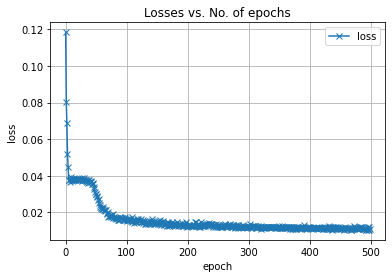

In [ ]:
plot_history(ae.training_routine(range(start,500),train_loader,val_loader,"checkpoints/"))

## Testing

In [7]:
ckpt="checkpoints/492_best.pth"

ckpt=torch.load(ckpt)
ae=AE().to(device)
ae.load_state_dict(ckpt["AE"])
ae.optimizer.load_state_dict(ckpt["AE_optim"])
ae.eval();

In [8]:
patient_info=np.load("preprocessed/patient_info.npy",allow_pickle=True).item()

In [ ]:
if not os.path.exists("postprocessed/measures"):
  os.makedirs("postprocessed/measures")
for model in sorted(test_loaders.keys()):
  if not os.path.exists("postprocessed/predictions/{}".format(model)):
    os.makedirs("postprocessed/predictions/{}".format(model))
  results=testing(ae,test_loaders[model],patient_info,"data/predictions/{}".format(model),"postprocessed/predictions/{}".format(model))
  np.save("postprocessed/measures/{}_AE.npy".format(model),results)

### Single patient

In [12]:
model="Bai"
patient_id=102
phase="ED"

prediction=nib.load("data/predictions/{}/patient{:03d}_{}.nii.gz".format(model,patient_id,phase)).get_fdata().transpose(2,1,0)
reconstruction=nib.load("postprocessed/predictions/{}/patient{:03d}_{}.nii.gz".format(model,patient_id,phase)).get_fdata().transpose(2,1,0)

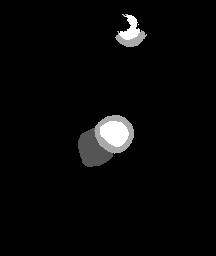

In [30]:
display_image(prediction[2])

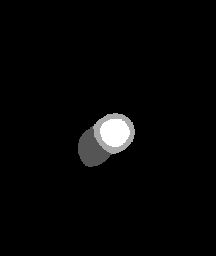

In [31]:
display_image(reconstruction[2])

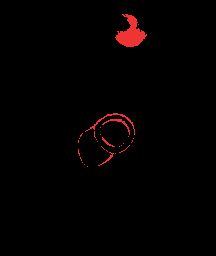

In [37]:
display_difference(prediction[2],reconstruction[2])

### Plots

In [7]:
models=["Bai","Baumgartner","Tziritas and Grinias","Isensee","Khened","Yang"]
plots=process_results(models,"data/measures/","postprocessed/measures/")

Anomalies (DSC=0/HD=nan): 16
Spotted by CA: 15
False Positive by CA: 3
Total discarded from the next plots: 19


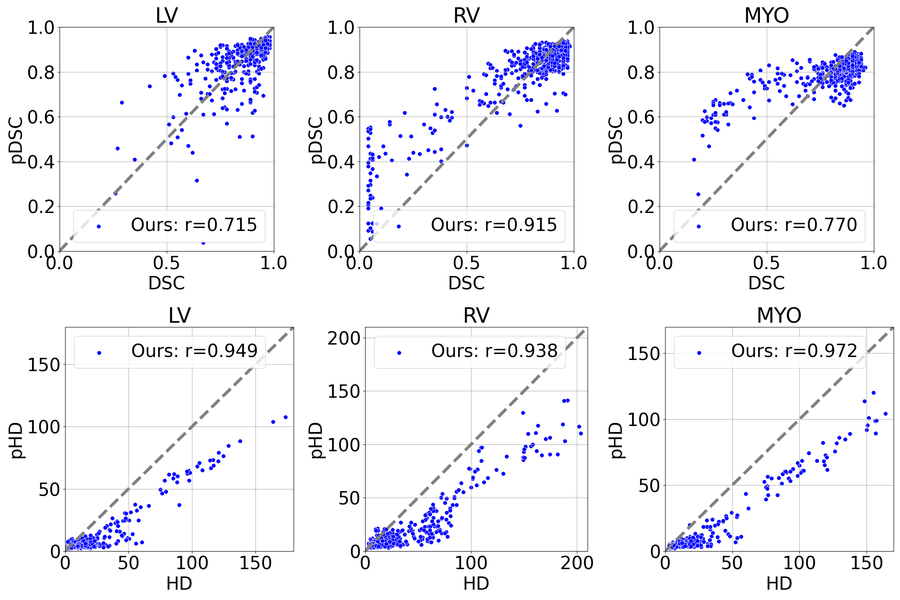

In [8]:
display_plots(plots)